In [6]:
import codecs
from dataclasses import dataclass
from typing import List, Dict, Any

import numpy as np
import pandas as pd
import torch
from torch import Tensor, nn
import time

import random
random.seed(0)
torch.manual_seed(0)

# from transformers import BertTokenizer, BertModel
# bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
# bert_model = BertModel.from_pretrained("bert-base-cased")
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '/work/nlp-project')
from scripts.read_write_data import read_processed_data, write_baseline_pred
from scripts.evaluation_functions import f1_score, tag_accuracy
from models.classes import DataIterator, Batch

from gensim.models import KeyedVectors
GoogleEmbs = KeyedVectors.load_word2vec_format('/work/nlp-project/models/GoogleNews-50k.bin', binary=True)

import matplotlib.pyplot as plt

In [7]:
TRAIN_PATH = "nlp-project/data/processed/train.conll"
DEV_PATH = "nlp-project/data/processed/dev.conll"
TEST_PATH = "nlp-project/data/processed/test.conll"

# Loading data
x_train = []
y_train = []
for words, labels, _, _ in read_processed_data(TRAIN_PATH):
    x_train.append(words)
    y_train.append(labels)

x_dev = []
y_dev = []
for words, labels, _, _ in read_processed_data(DEV_PATH):
    x_dev.append(words)
    y_dev.append(labels)

In [33]:
class BiLSTM(torch.nn.Module):
    def __init__(self,
                embedding_type = 'google',
                LSTM_HIDDEN=20,
                max_len=100,
                n_labels=3,
                batch_size=32,
                pad_token="<PAD>",
                pad_label=2
                ):
        super().__init__()
        
        self.embedding_type = embedding_type  # 'bert' (doesn't work) or 'google' for where to get embeddings from
        if embedding_type == 'google':
            self.EMBEDDING_DIM = 300  # length of embedding vectors
        elif embedding_type == 'bert':
            self.EMBEDDING_DIM = 768  # length of embedding vectors
        else:
            raise AttributeError("Must")
        self.LSTM_HIDDEN = LSTM_HIDDEN  # number of LSTM cells
        self.max_len=max_len  # maximum input sentence length, will be padded to this size
        self.n_labels = n_labels
        self.lstm = nn.LSTM(input_size=self.EMBEDDING_DIM, hidden_size=self.LSTM_HIDDEN, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(in_features=2 * self.LSTM_HIDDEN, out_features=n_labels)
        self.batch_size = batch_size
        self.pad_token = pad_token
        self.pad_label = pad_label

        # Logs for performance
        self.train_f1_log = []
        self.dev_f1_log = []

    def pad_inputs(self, collection: List[List[int]], padding_token):
        to_series = [pd.Series(el) for el in collection]
        enc_matrix = (pd.concat(to_series, axis=1)
                        .reindex(range(self.max_len))
                        .fillna(padding_token)
                        .T)
        collection = enc_matrix.values.tolist()
        return collection

    def forward(self, inputs):
        '''
        Implements a forward pass through the BiLSTM.
        inputs are a batch (list) of sentences.
        '''
        if self.embedding_type == 'bert':
            word_embeds = self._get_bert_embeds(inputs)
        elif self.embedding_type == 'google':
            word_embeds = self._get_google_embeds(inputs)
        # word_embeds = nn.Dropout(p=0.2)(word_embeds)
        lstm_result, _ = self.lstm(word_embeds)
        # lstm_result = nn.Dropout(p=0.3)(lstm_result)
        tags = self.linear(lstm_result)
        log_probs = torch.nn.functional.softmax(tags, dim=2)
        return log_probs
    
    def _get_google_embeds(self, inputs):
        embeddings = torch.Tensor()
        for sentence in inputs:
            sentence_embeds = torch.Tensor()
            for word in sentence:
                if GoogleEmbs.__contains__(word):
                    embed = GoogleEmbs.get_vector(word)
                    embed.setflags(write = True)
                    embed = torch.from_numpy(embed)
                else:
                    embed = torch.zeros(300)  # the word is not in the model dictionary, so use zero vector
                sentence_embeds = torch.cat((sentence_embeds, embed), dim=0)
            embeddings = torch.cat((embeddings, sentence_embeds), dim=0)
        return embeddings.view(len(inputs), -1, self.EMBEDDING_DIM)

    # def _get_bert_embeds(self, inputs):
    #     embeddings = torch.Tensor().float()
    #     for sentence in inputs:

    #         input_ids = torch.Tensor([bert_tokenizer.convert_tokens_to_ids(sentence)]).long()
    #         sentence_embeds = bert_model(input_ids)[0][0].float()

    #         embeddings = torch.cat((embeddings, sentence_embeds), dim=0).float()
    #     return embeddings.view(len(inputs), -1, self.EMBEDDING_DIM).float()
    
    def fit(self, documents, labels, dev=None, LEARNING_RATE=0.01, EPOCHS=3):
        
        # Padding data
        padded_documents = self.pad_inputs(documents, self.pad_token)
        padded_labels = self.pad_inputs(labels, self.pad_label)
        padded_labels = [list(map(int,sentence)) for sentence in padded_labels]

        if dev is not None:  # padding dev data if supplied
            dev_docs, dev_labs = dev
            padded_dev_docs = self.pad_inputs(dev_docs, self.pad_token)
            padded_dev_labs = self.pad_inputs(dev_labs, self.pad_label)
            padded_dev_labs = [list(map(int,s)) for s in padded_dev_labs]

        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        loss_func = torch.nn.CrossEntropyLoss(reduction='sum', ignore_index=self.pad_label)  # ignores loss for padding token
        data_iterator = DataIterator(batch_size=self.batch_size)

        for epoch in range(EPOCHS):
            epoch_loss = 0
            
            # TRAINING
            self.train()
            batch_f1s = []  
            for i, batch in enumerate(data_iterator(padded_documents, padded_labels)):
                pred_tags = self.forward(inputs=batch.inputs)
                pred_tags = pred_tags.view(-1, self.n_labels) # probability distribution for each tag across all words in batch
                targets = torch.tensor(batch.targets).flatten()  # true label for each word
                batch_loss = loss_func(pred_tags, targets)
                epoch_loss += batch_loss.item()
                batch_loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                batch_f1 = f1_score(targets, pred_tags, pad_label=self.pad_label, relaxed=False)  # exact match f1
                batch_f1s.append(batch_f1)
            train_epoch_f1 = round(np.mean(batch_f1s), 3)  # mean f1 over batches in epoch
            self.train_f1_log.append(train_epoch_f1)

            # lr_scheduler.step()

            if dev is None: continue  # Go to next epoch if no dev data is supplied
            
            # DEV EVALUATION
            self.eval()
            batch_f1s = []
            for i, batch in enumerate(data_iterator(padded_dev_docs, padded_dev_labs)):
                with torch.no_grad():
                    pred_dev = self.forward(batch.inputs)
                pred_dev = pred_dev.view(-1, self.n_labels) 
                targets = torch.tensor(batch.targets).flatten()

                batch_f1 = f1_score(targets, pred_dev, pad_label=self.pad_label, relaxed=False)  # exact match f1
                batch_f1s.append(batch_f1)

            dev_epoch_f1 = round(np.mean(batch_f1s), 3)  # mean f1 over batches in epoch
            self.dev_f1_log.append(dev_epoch_f1)
            
            if dev is None:
                print(f"Epoch {epoch}, train: {self.train_f1_log[epoch]}, loss: {epoch_loss:.3f}")
            else:
                print(f"Epoch {epoch}, train: {self.train_f1_log[epoch]}, dev: {self.dev_f1_log[epoch]}")

In [36]:
model = BiLSTM(LSTM_HIDDEN=15)
model.fit(x_train, y_train, dev=(x_dev,y_dev), LEARNING_RATE=0.05, EPOCHS=40)

Epoch 0, train: 0.0, dev: 0.0
Epoch 1, train: 0.0, dev: 0.0
Epoch 2, train: 0.0, dev: 0.0
Epoch 3, train: 0.0, dev: 0.0
Epoch 4, train: 0.0, dev: 0.0
Epoch 5, train: 0.0, dev: 0.0
Epoch 6, train: 0.0, dev: 0.0
Epoch 7, train: 0.0, dev: 0.0
Epoch 8, train: 0.0, dev: 0.0
Epoch 9, train: 0.0, dev: 0.0
Epoch 10, train: 0.0, dev: 0.0
Epoch 11, train: 0.0, dev: 0.0
Epoch 12, train: 0.0, dev: 0.0
Epoch 13, train: 0.0, dev: 0.0
Epoch 14, train: 0.0, dev: 0.0
Epoch 15, train: 0.0, dev: 0.0
Epoch 16, train: 0.0, dev: 0.0
Epoch 17, train: 0.0, dev: 0.0
Epoch 18, train: 0.0, dev: 0.0
Epoch 19, train: 0.0, dev: 0.0
Epoch 20, train: 0.0, dev: 0.0
Epoch 21, train: 0.0, dev: 0.0
Epoch 22, train: 0.0, dev: 0.0
Epoch 23, train: 0.0, dev: 0.0
Epoch 24, train: 0.021, dev: 0.315
Epoch 25, train: 0.531, dev: 0.557
Epoch 26, train: 0.599, dev: 0.579
Epoch 27, train: 0.624, dev: 0.594
Epoch 28, train: 0.635, dev: 0.588
Epoch 29, train: 0.639, dev: 0.6
Epoch 30, train: 0.644, dev: 0.606
Epoch 31, train: 0.652,

KeyboardInterrupt: 

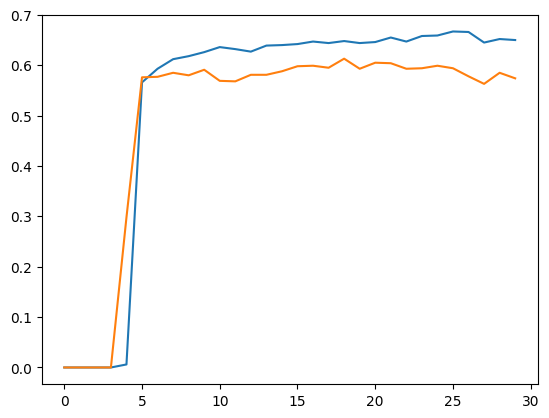

In [16]:
plt.plot(model.train_f1_log)
plt.plot(model.dev_f1_log)

In [29]:
optimizer = torch.optim.Adam([torch.Tensor(0),torch.Tensor(1)], lr=0.2)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
for epoch in range(40):
    optimizer.step()
    lr_scheduler.step()
    print(lr_scheduler.get_last_lr())

[0.18000000000000002]
[0.16200000000000003]
[0.14580000000000004]
[0.13122000000000003]
[0.11809800000000004]
[0.10628820000000004]
[0.09565938000000004]
[0.08609344200000005]
[0.07748409780000004]
[0.06973568802000003]
[0.06276211921800003]
[0.056485907296200025]
[0.050837316566580026]
[0.04575358490992203]
[0.04117822641892983]
[0.03706040377703684]
[0.03335436339933316]
[0.030018927059399847]
[0.027017034353459864]
[0.02431533091811388]
[0.02188379782630249]
[0.019695418043672242]
[0.01772587623930502]
[0.015953288615374518]
[0.014357959753837067]
[0.012922163778453361]
[0.011629947400608026]
[0.010466952660547223]
[0.0094202573944925]
[0.008478231655043252]
[0.007630408489538927]
[0.006867367640585034]
[0.0061806308765265305]
[0.005562567788873878]
[0.00500631100998649]
[0.004505679908987841]
[0.004055111918089057]
[0.0036496007262801517]
[0.0032846406536521365]
[0.0029561765882869227]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b2f14aee-af04-4db5-af55-57a3a58b9f40' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>